# Build a DNN using the Keras Functional API




## Learning objectives

1. Review how to read in CSV file data using tf.data.
2. Specify input, hidden, and output layers in the DNN architecture.
3. Review and visualize the final DNN shape.
4. Train the model locally and visualize the loss curves.
5. Deploy and predict with the model using Cloud AI Platform. 


## Introduction

In this notebook, we will build a Keras DNN to predict the fare amount for NYC taxi cab rides.

Each learning objective will correspond to a __#TODO__ in the [student lab notebook](../labs/neural_network.ipynb) -- try to complete that notebook first before reviewing this solution notebook. 

In [1]:
!sudo chown -R jupyter:jupyter /home/jupyter/training-data-analyst

In [2]:
!sudo apt-get install graphviz -y

In [1]:
# You can use any Python source file as a module by executing an import statement in some other Python source file
# The import statement combines two operations; it searches for the named module, then it binds the
# results of that search to a name in the local scope.
import os, json, math
# Import data processing libraries like Numpy and TensorFlow
import numpy as np
import tensorflow as tf
# Python shutil module enables us to operate with file objects easily and without diving into file objects a lot.
import shutil
# Show the currently installed version of TensorFlow
print("TensorFlow version: ",tf.version.VERSION)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # SET TF ERROR LOG VERBOSITY

TensorFlow version:  2.13.1


## Locating the CSV files

We will start with the CSV files that we wrote out in the other notebook. Just so you don't have to run the notebook, we saved a copy in ../data/toy_data

In [2]:
# `ls` is a Linux shell command that lists directory contents
# `l` flag list all the files with permissions and details
!ls -l ../data/toy_data/*.csv

-rw-r--r--  1 zhao  staff  1111933 Jul 22 10:51 ../data/toy_data/taxi-traffic-test_toy.csv
-rw-r--r--  1 zhao  staff  4772181 Jul 22 10:51 ../data/toy_data/taxi-traffic-train_toy.csv
-rw-r--r--  1 zhao  staff  1038564 Jul 22 10:51 ../data/toy_data/taxi-traffic-valid_toy.csv


## Lab Task 1: Use tf.data to read the CSV files


First let's define our columns of data, which column we're predicting for, and the default values.

In [3]:
# Define columns of data
CSV_COLUMNS  = ['fare_amount',  'pickup_datetime',
                'pickup_longitude', 'pickup_latitude', 
                'dropoff_longitude', 'dropoff_latitude', 
                'passenger_count', 'key']
LABEL_COLUMN = 'fare_amount'
DEFAULTS     = [[0.0],['na'],[0.0],[0.0],[0.0],[0.0],[0.0],['na']]

Next, let's define our features we want to use and our label(s) and then load in the dataset for training.

In [4]:
# Define features you want to use
def features_and_labels(row_data):
    for unwanted_col in ['pickup_datetime', 'key']:
        row_data.pop(unwanted_col)
    label = row_data.pop(LABEL_COLUMN)
    return row_data, label  # features, label

# load the training data
def load_dataset(pattern, batch_size=1, mode=tf.estimator.ModeKeys.EVAL):
  dataset = (tf.data.experimental.make_csv_dataset(pattern, batch_size, CSV_COLUMNS, DEFAULTS)
             .map(features_and_labels) # features, label
             )
  if mode == tf.estimator.ModeKeys.TRAIN:
        dataset = dataset.shuffle(1000).repeat()
  dataset = dataset.prefetch(1) # take advantage of multi-threading; 1=AUTOTUNE
  return dataset

## Lab Task 2: Build a DNN with Keras

Now let's build the Deep Neural Network (DNN) model in Keras and specify the input and hidden layers. We will print out the DNN architecture and then visualize it later on.

In [5]:
# Build a simple Keras DNN using its Functional API
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true))) 

def build_dnn_model():
    INPUT_COLS = ['pickup_longitude', 'pickup_latitude', 
                  'dropoff_longitude', 'dropoff_latitude', 
                  'passenger_count']

    # TODO 2
    # input layer
    inputs = {
        colname : tf.keras.layers.Input(name=colname, shape=(), dtype='float32')
           for colname in INPUT_COLS
    }
    # tf.feature_column.numeric_column() represents real valued or numerical features.
    feature_columns = {
        colname : tf.feature_column.numeric_column(colname)
           for colname in INPUT_COLS
    }
    
    # the constructor for DenseFeatures takes a list of numeric columns
    # The Functional API in Keras requires that you specify: LayerConstructor()(inputs)
    dnn_inputs = tf.keras.layers.DenseFeatures(feature_columns.values())(inputs)

    # two hidden layers of [32, 8] just in like the BQML DNN
    h1 = tf.keras.layers.Dense(32, activation='relu', name='h1')(dnn_inputs)
    h2 = tf.keras.layers.Dense(8, activation='relu', name='h2')(h1)

    # final output is a linear activation because this is regression
    output = tf.keras.layers.Dense(1, activation='linear', name='fare')(h2)
    model = tf.keras.models.Model(inputs, output)
    model.compile(optimizer='adam', loss='mse', metrics=[rmse, 'mse'])
    return model

print("Here is our DNN architecture so far:\n")
model = build_dnn_model()
print(model.summary())

Here is our DNN architecture so far:

Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 dropoff_latitude (InputLay  [(None,)]                    0         []                            
 er)                                                                                              
                                                                                                  
 dropoff_longitude (InputLa  [(None,)]                    0         []                            
 yer)                                                                                 

## Lab Task 3: Visualize the DNN

We can visualize the DNN using the Keras [plot_model](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/utils/plot_model) utility.

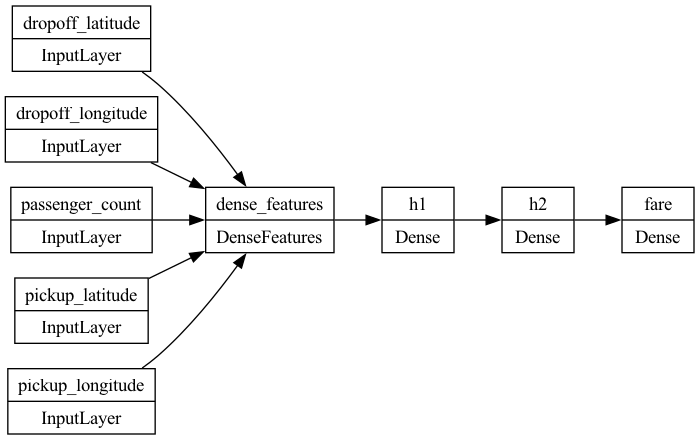

In [11]:
# tf.keras.utils.plot_model() Converts a Keras model to dot format and save to a file.
tf.keras.utils.plot_model(model, 'dnn_model.png', show_shapes=False, rankdir='LR')

## Lab Task 4: Train the model

To train the model, simply call [model.fit()](https://keras.io/models/model/#fit).

Note that we should really use many more NUM_TRAIN_EXAMPLES (i.e. a larger dataset). We shouldn't make assumptions about the quality of the model based on training/evaluating it on a small sample of the full data.

In [12]:
TRAIN_BATCH_SIZE = 32
NUM_TRAIN_EXAMPLES = 10000 * 5 # training dataset repeats, so it will wrap around
NUM_EVALS = 32  # how many times to evaluate
NUM_EVAL_EXAMPLES = 10000 # enough to get a reasonable sample, but not so much that it slows down

trainds = load_dataset('../data/toy_data/taxi-traffic-train*', TRAIN_BATCH_SIZE, tf.estimator.ModeKeys.TRAIN)
evalds = load_dataset('../data/toy_data/taxi-traffic-valid*', 1000, tf.estimator.ModeKeys.EVAL).take(NUM_EVAL_EXAMPLES//1000)

steps_per_epoch = NUM_TRAIN_EXAMPLES // (TRAIN_BATCH_SIZE * NUM_EVALS)

# Model Fit
history = model.fit(trainds, 
                    validation_data=evalds,
                    epochs=NUM_EVALS, 
                    steps_per_epoch=steps_per_epoch)

Epoch 1/32
48/48 [==============================] - 1s 6ms/step - loss: 84.8701 - rmse: 8.7926 - mse: 84.8701 - val_loss: 85.5311 - val_rmse: 9.2173 - val_mse: 85.5311
Epoch 2/32
48/48 [==============================] - 0s 5ms/step - loss: 86.8199 - rmse: 8.8070 - mse: 86.8199 - val_loss: 84.9416 - val_rmse: 9.2000 - val_mse: 84.9416
Epoch 3/32
48/48 [==============================] - 0s 5ms/step - loss: 69.5649 - rmse: 8.0502 - mse: 69.5649 - val_loss: 83.1973 - val_rmse: 9.1028 - val_mse: 83.1973
Epoch 4/32
48/48 [==============================] - 0s 5ms/step - loss: 81.1420 - rmse: 8.5816 - mse: 81.1420 - val_loss: 88.1376 - val_rmse: 9.3705 - val_mse: 88.1376
Epoch 5/32
48/48 [==============================] - 0s 5ms/step - loss: 99.2314 - rmse: 9.4763 - mse: 99.2314 - val_loss: 82.4607 - val_rmse: 9.0584 - val_mse: 82.4607
Epoch 6/32
48/48 [==============================] - 0s 5ms/step - loss: 123.9868 - rmse: 10.2225 - mse: 123.9868 - val_loss: 85.8830 - val_rmse: 9.2566 - val_ms

### Visualize the model loss curve

Next, we will use matplotlib to draw the model's loss curves for training and validation.

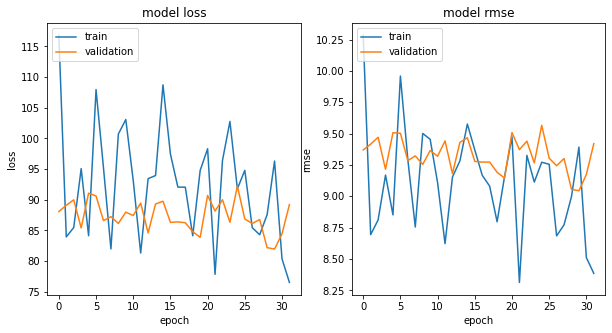

In [9]:
# plot
# Use matplotlib for visualizing the model
import matplotlib.pyplot as plt
nrows = 1
ncols = 2
# The .figure() method will create a new figure, or activate an existing figure.
fig = plt.figure(figsize=(10, 5))

for idx, key in enumerate(['loss', 'rmse']):
    ax = fig.add_subplot(nrows, ncols, idx+1)
# The .plot() is a versatile function, and will take an arbitrary number of arguments. For example, to plot x versus y.
    plt.plot(history.history[key])
    plt.plot(history.history['val_{}'.format(key)])
# The .title() method sets a title for the axes.
    plt.title('model {}'.format(key))
    plt.ylabel(key)
    plt.xlabel('epoch')
# The .legend() method will place a legend on the axes.
    plt.legend(['train', 'validation'], loc='upper left');

## Lab Task 5: Predict with the model locally

To predict with Keras, you simply call [model.predict()](https://keras.io/models/model/#predict) and pass in the cab ride you want to predict the fare amount for.

In [10]:
# TODO 5
# Use the model to do prediction with `model.predict()`
model.predict({
    'pickup_longitude': tf.convert_to_tensor([-73.982683]),
    'pickup_latitude': tf.convert_to_tensor([40.742104]),
    'dropoff_longitude': tf.convert_to_tensor([-73.983766]),
    'dropoff_latitude': tf.convert_to_tensor([40.755174]),
    'passenger_count': tf.convert_to_tensor([3.0]),    
}, steps=1)

1/1 [==============================] - 0s 99ms/step


array([[-4.582888]], dtype=float32)

Of course, this is not realistic, because we can't expect client code to have a model object in memory. We'll have to export our model to a file, and expect client code to instantiate the model from that exported file.

Copyright 2021 Google Inc.
Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at
http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.